In [10]:
from ase.io import read, write
from ase import Atoms
import pickle
from ocdata.core import Adsorbate, Slab, Bulk, AdsorbateSlabConfig
import os
import json
from ocdata.databases.pkls import BULK_PKL
import gzip
import matplotlib.pyplot as plt
import re

In [7]:
with open(BULK_PKL, 'rb') as f:
    all_bulks_ocdata = pickle.load(file=f)

with open('oc22_metadata.pkl', 'rb') as f:
    oc22_data = pickle.load(file=f)

oc22_data

{14892: {'bulk_id': 'mp-10390',
  'miller_index': (2, 2, -1),
  'nads': 1,
  'traj_id': 'Ta2O5_mp-10390_Ckjw95OuOa_xlcyfgkuFa',
  'bulk_symbols': 'Ta8O20',
  'slab_sid': 14089,
  'ads_symbols': 'HO2'},
 6627: {'bulk_id': 'mp-505365',
  'miller_index': (0, 0, 1),
  'nads': 1,
  'traj_id': 'Mg3Nb6O11_mp-505365_irYkJvcoQ8_jMyG5G2tlJ',
  'bulk_symbols': 'Mg3Nb6O11',
  'slab_sid': 5790,
  'ads_symbols': 'H2O'},
 75924: {'bulk_id': 'mp-674298',
  'miller_index': (0, 1, 0),
  'nads': 1,
  'traj_id': 'Al22CdO34_mp-674298_u9MYbadfCN_nNUUW73Lie',
  'bulk_symbols': 'Al44Cd2O68',
  'slab_sid': 71646,
  'ads_symbols': 'C'},
 29818: {'bulk_id': 'mp-28403',
  'miller_index': (2, 1, 0),
  'nads': 0,
  'bulk_symbols': 'Ba8W4O20'},
 6077: {'bulk_id': 'mp-684697',
  'miller_index': (1, 0, 0),
  'nads': 0,
  'traj_id': 'Sc20O19_mp-684697_clean_nZSg3yaZgm',
  'bulk_symbols': 'Sc40O38'},
 8121: {'bulk_id': 'mp-7561',
  'miller_index': (1, 0, 0),
  'nads': 0,
  'traj_id': 'SrPd3O4_mp-7561_clean_4E04ZYdDtf',


In [6]:
list_of_mp_ids_oxides = list()
for keys, values in oc22_data.items():
     if re.search(r'O\d*$', values["bulk_symbols"]):
        list_of_mp_ids_oxides.append(values['bulk_id'])

NameError: name 'oc22_data' is not defined

In [39]:
def extract_elements(formula):
    elements = re.findall(r'[A-Z][a-z]*', formula)
    return elements

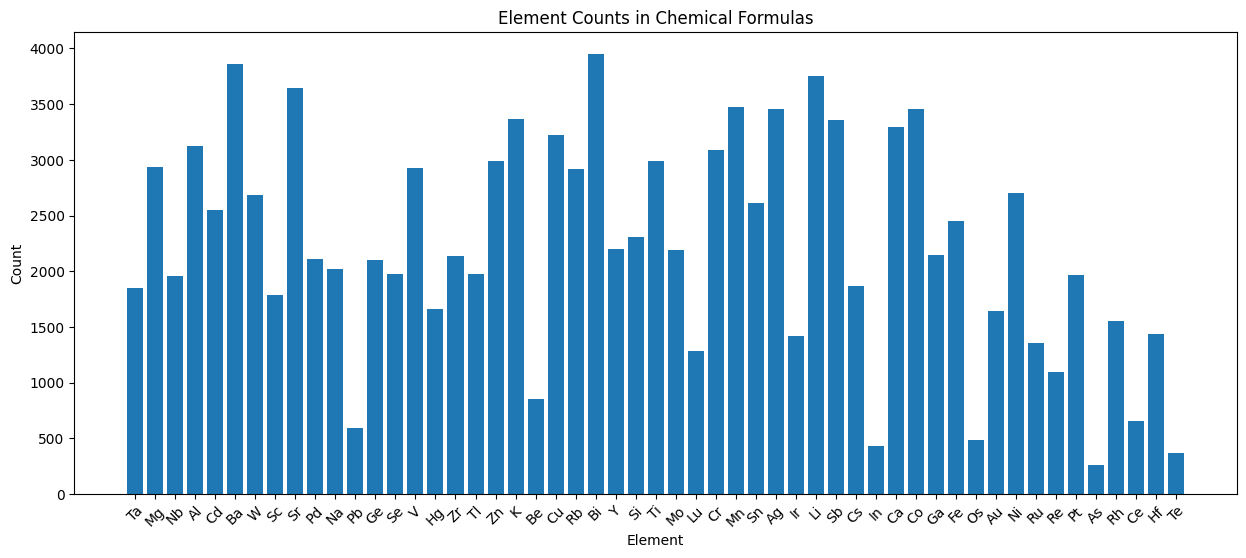

In [54]:
element_counts = {}
for key, info in oc22_data.items():
    elements = extract_elements(info["bulk_symbols"])
    for element in elements:
        if element in element_counts:
            element_counts[element] += 1
        else:
            element_counts[element] = 1
del element_counts["O"]
# Create a bar chart
elements = list(element_counts.keys())
counts = list(element_counts.values())

plt.figure(figsize=(15, 6))
plt.bar(elements, counts, )
plt.xlabel("Element")
plt.ylabel("Count")
plt.title("Element Counts in Chemical Formulas")
plt.xticks(rotation=45)
plt.show()

In [22]:
"R" in all_bulks[0].get('atoms').get_chemical_formula()
oxide_bulks = list()
for bulk in all_bulks:
    if 6 in bulk.get('atoms').numbers:
        oxide_bulks.append(bulk)

In [9]:
from input_gen import OCPInputGenerator
adsorbates_path = "/scratch/project_2005750/adsorbants/ocp_ecut_450"
bulk_path = "/scratch/project_2005750/bulks_opt/ZnO/"
ocp_input = OCPInputGenerator(adsorbates_path=adsorbates_path, bulk_path=bulk_path, is_metal=False, bulk_material_id='ZnO_mp-2133')
# new_ads_infor = ocp_input.update_adsorbates_info()
# ocp_input.create_and_save_all_adslabs()

In [12]:
import os
from ase.io import read, write
from ase.atoms import Atoms


class BestSurfaces():
    def __init__(self, path_to_slabs, material_id):
        self.path_to_slabs = path_to_slabs
        self.material_id = material_id
        self.slab_files = self.list_files_of_relaxed_slabs()
        self.unique_millers = self.get_millers()
        self.slabs_info_dict = self.sort_slabs_based_on_millers()
        self.slabs_info_dict = self.get_energies_and_best_surfaces()
        pass

    def list_files_of_relaxed_slabs(self):
        slab_files = [file for file in os.listdir(self.path_to_slabs) if self.material_id in file and file.endswith('.traj')]
        return slab_files

    def get_millers(self):
        all_millers = list()
        for slabfile in self.slab_files:
            miller_string = slabfile.split('_')[2]
            all_millers.append(miller_string)
        
        return list(set(all_millers))

    def sort_slabs_based_on_millers(self):
        slabs_info_dict = dict()
        for miller in self.unique_millers:
            slabs_info_dict[miller] = dict()
            filtered_list = list()
            for slab_file in self.slab_files:
                if miller in slab_file:
                    filtered_list.append(slab_file)
            slabs_info_dict[miller]['slabfiles'] = filtered_list
        return slabs_info_dict

    def get_energies_and_best_surfaces(self):
        with open(os.path.join(self.path_to_slabs, 'best_surfaces.txt'), 'w') as f:
            for miller, info in self.slabs_info_dict.items():
                total_energies = list()
                energy_per_atom = list()
                for slabfile in info['slabfiles']:
                    filepath = os.path.join(self.path_to_slabs, slabfile)
                    atoms_obj = read(filepath)
                    toten = atoms_obj.get_potential_energy()
                    natoms = atoms_obj.get_global_number_of_atoms()
                    e_per_atom = toten/natoms
                    total_energies.append(toten)
                    energy_per_atom.append(e_per_atom)
                info['total_energies'] = total_energies
                info['energy_per_atom'] = energy_per_atom
                min_energy = min(energy_per_atom)
                info['min_energy'] = min_energy
                min_energy_surface = info['slabfiles'][energy_per_atom.index(min_energy)]
                print(min_energy_surface, min_energy, file=f)
                info['min_energy_surface'] = min_energy_surface
        return self.slabs_info_dict
    
    def save_best_surface_images(self):
        path_to_images = os.path.join(self.path_to_slabs, 'images')
        if not os.path.exists(path_to_images):
            os.makedirs(path_to_images)
        for miller, info in self.slabs_info_dict.items():
            best_surface = read(os.path.join(self.path_to_slabs, info['min_energy_surface']))
            write(os.path.join(path_to_images, info['min_energy_surface'].split('.')[0] + '.png'), best_surface, rotation='10z,-80x')

    

In [16]:
slab_path = "/scratch/project_2005750/Surf_adsorprion_energy_calc_OCP/ZnO_mp-2133_ads_OCP/slabs/"
#zno_surface = BestSurfaces(path_to_slabs=slab_path, material_id='mp-2133')
#zno_surface.save_best_surface_images()
#zno_surface.slabs_info_dict

In [8]:
zno_surface.slabs_info_dict #.get('best_surface')

{'+2+1+1': {'slabfiles': ['ZnO_mp-2133_+2+1+1_T_14.traj',
   'ZnO_mp-2133_+2+1+1_F_08.traj',
   'ZnO_mp-2133_+2+1+1_F_20.traj',
   'ZnO_mp-2133_+2+1+1_F_14.traj',
   'ZnO_mp-2133_+2+1+1_T_20.traj',
   'ZnO_mp-2133_+2+1+1_T_08.traj'],
  'total_energies': [-591.3767700195312,
   -606.695556640625,
   -606.7796020507812,
   -591.732421875,
   -606.8869018554688,
   -606.8743896484375],
  'energy_per_atom': [-4.1067831251356335,
   -4.213163587782118,
   -4.2137472364637585,
   -4.1092529296875,
   -4.214492373996311,
   -4.2144054836697045],
  'min_energy': -4.214492373996311,
  'min_energy_surface': 'ZnO_mp-2133_+2+1+1_T_20.traj'},
 '+1+0+2': {'slabfiles': ['ZnO_mp-2133_+1+0+2_F_18.traj',
   'ZnO_mp-2133_+1+0+2_T_18.traj',
   'ZnO_mp-2133_+1+0+2_F_12.traj',
   'ZnO_mp-2133_+1+0+2_T_29.traj',
   'ZnO_mp-2133_+1+0+2_T_12.traj',
   'ZnO_mp-2133_+1+0+2_T_07.traj',
   'ZnO_mp-2133_+1+0+2_F_07.traj',
   'ZnO_mp-2133_+1+0+2_F_29.traj'],
  'total_energies': [-302.92193603515625,
   -302.78314208

In [25]:
import pandas as pd
best_surface_df = pd.read_csv(os.path.join(slab_path, "best_surfaces.txt"), delimiter=' ', header=None)
_best_surface_list = list(best_surface_df.sort_values(by=1).iloc[:,0])

In [36]:
atoms_ = read(os.path.join(slab_path, "ZnO_mp-2133_+0+0+1_F_19.traj" ))
precom_slab_pkl = "/scratch/project_2005750/Surf_adsorprion_energy_calc_OCP/ZnO_mp-2133_ads_OCP/slabs.pkl"
bulk_path = "/scratch/project_2005750/bulks_opt/ZnO/vasprun.xml"
bulk = read(bulk_path)
bulk_obj = Bulk(bulk_atoms=bulk)
slab_from_atoms = Slab.from_bulk_get_all_slabs(bulk=bulk_obj)

In [8]:
from input_gen import OCPInputGenerator
from ase.io import read
import os

adsorbates_path = "/scratch/project_2005750/adsorbants/ocp_ecut_450"
bulk_path = "/scratch/project_2005750/bulks_opt/ZnO/"
save_path = "/scratch/project_2005750/Surf_adsorprion_energy_calc_OCP/ZnO_mp-2133_ads_OCP/adslabs"

ocp_inputs = OCPInputGenerator(adsorbates_path=adsorbates_path,
                              bulk_path=bulk_path,
                              is_metal=False, 
                              bulk_material_id='ZnO_mp-2133',
                              save_path=save_path)

In [11]:
precom_slab_pkl = "/scratch/project_2005750/Surf_adsorprion_energy_calc_OCP/ZnO_mp-2133_ads_OCP/slabs.pkl"
bulk = read(os.path.join(bulk_path, 'vasprun.xml'))
bulk_obj = Bulk(bulk_atoms=bulk)
slab_from_pkl = Slab.from_precomputed_slabs_pkl(bulk=bulk_obj, precomputed_slabs_pkl=precom_slab_pkl)

In [26]:
best_surface_list = [surface.replace('traj', 'json') for surface in _best_surface_list]

In [27]:
full_list = dict()
for slab in slab_from_pkl:
    name = ocp_inputs._name_for_slab(slab=slab, adslab_num=None, adsorbate_suffix=None)
    full_list[name] = slab

In [30]:
adsorbate_info = ocp_inputs.update_adsorbates_info()

best_slabs_dict = dict()
for slab in best_surface_list:
    best_slabs_dict[slab] = full_list[slab]

In [31]:
adsorbate_info

{'d_H': {'suffix': '-H',
  'binding_index': [0],
  'atoms_obj': Atoms(symbols='H', pbc=True, cell=[20.0, 20.0, 20.0], calculator=SinglePointDFTCalculator(...)),
  'ocp_adsorbate': Adsorbate: (H)},
 'd_OH': {'suffix': '-OH',
  'binding_index': [0],
  'atoms_obj': Atoms(symbols='OH', pbc=True, cell=[20.0, 20.0, 20.0], calculator=SinglePointDFTCalculator(...)),
  'ocp_adsorbate': Adsorbate: (HO)},
 'm_CO': {'suffix': '-CO',
  'binding_index': [0],
  'atoms_obj': Atoms(symbols='CO', pbc=True, cell=[20.0, 20.0, 20.0], calculator=SinglePointDFTCalculator(...)),
  'ocp_adsorbate': Adsorbate: (CO)},
 'd_OCH3': {'suffix': '-OCH3',
  'binding_index': [4],
  'atoms_obj': Atoms(symbols='CH3O', pbc=True, cell=[20.0, 20.0, 20.0], calculator=SinglePointDFTCalculator(...)),
  'ocp_adsorbate': Adsorbate: (CH3O)},
 'd_OCHO': {'suffix': '-OCHO',
  'binding_index': [1],
  'atoms_obj': Atoms(symbols='CO2H', pbc=True, cell=[20.0, 20.0, 20.0], calculator=SinglePointDFTCalculator(...)),
  'ocp_adsorbate': Ads

In [33]:
for slabname, slab in best_slabs_dict.items():
     for adsorbate_id, adsorbate in adsorbate_info.items():
        adslabs = AdsorbateSlabConfig(slab=slab, adsorbate=adsorbate['ocp_adsorbate'], mode='heuristic')
        for adslab_num, adslab in enumerate(adslabs.atoms_list):
                    save_filepath = os.path.join(save_path, 
                                                 ocp_inputs._name_for_slab(slab,
                                                                       adslab_num, 
                                                                       adsorbate['suffix']))
                    write(save_filepath, adslab, format='json') 

In [1]:
from input_gen import OCPInputGenerator

adsorbates_path = "/scratch/project_2005750/adsorbants/ocp_ecut_450"
bulk_path = "/scratch/project_2005750/bulks_opt/ZnO/"
save_path = "/scratch/project_2005750/Surf_adsorprion_energy_calc_OCP/ZnO_mp-2133_ads_OCP/adslabs"
best_slabs_csv = "/scratch/project_2005750/Surf_adsorprion_energy_calc_OCP/ZnO_mp-2133_ads_OCP/slabs/best_surfaces.txt"
precom_slab_pkl = "/scratch/project_2005750/Surf_adsorprion_energy_calc_OCP/ZnO_mp-2133_ads_OCP/slabs.pkl"
ocp_inputs = OCPInputGenerator(adsorbates_path=adsorbates_path,
                              bulk_path=bulk_path,
                              is_metal=False, 
                              bulk_material_id='ZnO_mp-2133',
                              save_path=save_path)

all_adslabs = ocp_inputs.create_specific_adslabs(path_to_best_slabs_csv=best_slabs_csv, precom_slab_pkl=precom_slab_pkl)

In [3]:
import json
adslab_json_path = "/scratch/project_2005750/Surf_adsorprion_energy_calc_OCP/ZnO_mp-2133_ads_OCP/adslabs.json"
with open(adslab_json_path, 'w') as f:
    json.dump(all_adslabs, f, indent = 6)

TypeError: Object of type Atoms is not JSON serializable